In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
import sys
import pylab as plt
from pickle import load

sys.path.append('./lib')
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions
from YearPlotter import YearPlotter

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/tak/anaconda/envs/CSE255/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['load', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import *

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])
sqlContext = SQLContext(sc)

In [13]:
sc.stop()

In [3]:
data_dir='../../Data/Weather'
file_index='SSSSBBBB'

filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

filename=data_dir+'/US_Weather_%s.parquet'%file_index
df=sqlContext.read.parquet(filename)
#print df.count()
#df.show(5)

YP=YearPlotter()

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


In [11]:
print mean(STAT['PRCP']['Mean'])/10.


0.997436605262


In [8]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    labels=None
    if m=='TMIN' or m=='TMAX':
        graphs/=10.
        axis.set_ylabel('Degrees Celsius')
        labels=['mean-std','mean','mean+std']
    if m=='PRCP':
        graphs/=10.
        axis.set_ylabel('millimeter / day')
        labels=['mean-std','mean','mean+std']
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m,labels=labels)
    
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    
def decompose(row):
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)

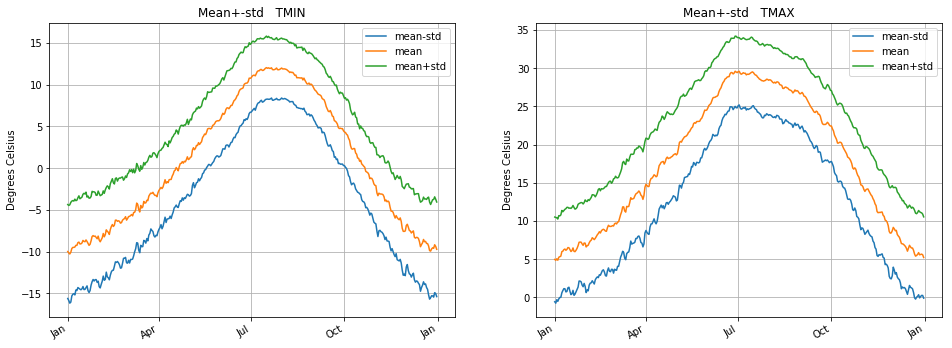

In [6]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

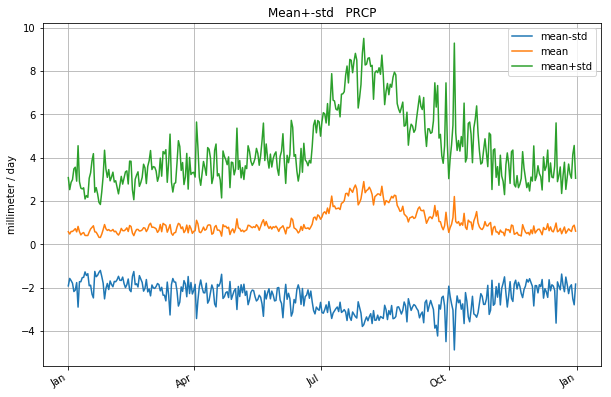

In [9]:
fig,ax=plt.subplots(figsize=(10,7));
plot_mean_std('PRCP',fig,ax)

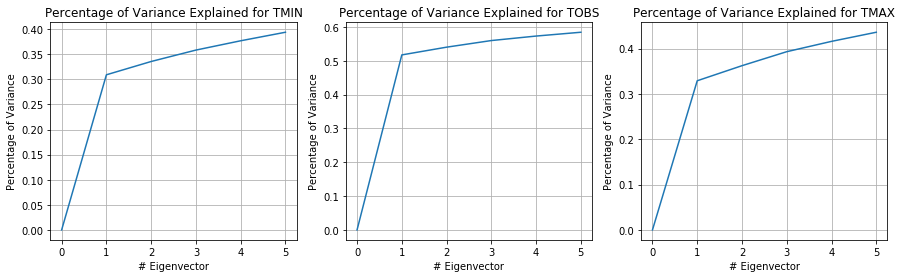

In [8]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

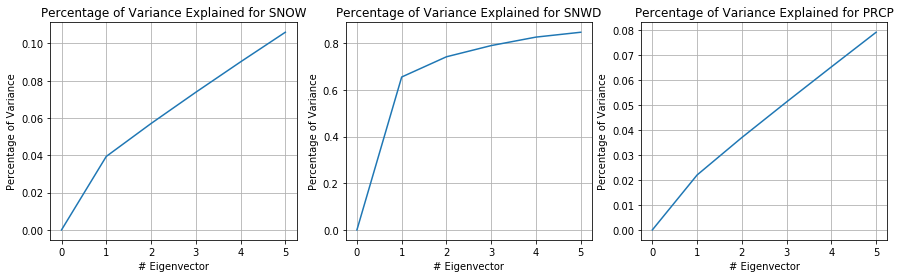

In [9]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 